# Mouse Maze 

A maze solved with 3 different levels of information.

1. MDP
2. POMDP
3. No state information

Ideas:
Add 'wind' to maze
Add telporters and traps
Maybe secret passages?
Keys and doors?

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import kruskal
import gym

from maze import Maze_MDP, Maze_POMDP
from utilities import clip, smooth, int_to_bits, bits_to_int, softmax
from collections import deque
from gym import error, spaces, utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


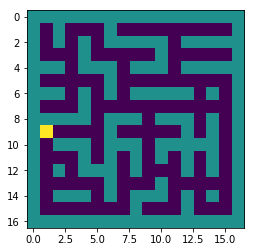

In [2]:
# quick test...
maze = Maze_MDP(17,17)
maze.generate_random(5)
maze.plot()

# 1. MDP

Solve the maze as a markov decision process.  We have perfect information in this case, so learning is realtively easy via q-learning.

We will implement the following 3 algorithms

* Sarasa
* TD-Learning
* Q-Learning

and evaluate how long it takes for them to converge on the optimal solution.

## 1.1 Sarsa

Apply the Sarsa algorithm to the problem.

In [3]:
class Sarsa_Agent():
    """ Sarsa algroithm """
    
    def __init__(self, env):
        self.Q = np.zeros((env.width,env.height,len(env.ACTIONS)))
        self.alpha = 0.5
        self.gamma = 1.0
        self.epsilon = 0.1
        self.env = env
    
    def policy_action(self, state, eps=None):
        """ returns sampled policy action at given state."""
        if np.random.rand() < (eps if eps is not None else self.epsilon):
            return np.random.randint(len(self.env.ACTIONS))
        else:
            x,y = state
            return np.random.choice(np.flatnonzero(self.Q[x,y] == self.Q[x,y].max()))        
        
    def show_policy(self):
        # display our policy        

        plt.imshow(self.env.tile)
        
        self.env.reset()
        x,y = self.env.state
        
        history = [(x,y,0)]
        
        for i in range(100):
            # take determinstic policy
            a = self.policy_action(self.env.state,0) 
            self.env.step(int(a))
            x,y = self.env.state
            history.append((x, y, i+1))
            if (x,y) == self.env.goal:
                print("Policy reached goal in {} steps".format(i+1))
                break
        else:
            print("Failed to find path to goal after {} steps.".format(i))

        X = [x for (x,y,c) in history]
        Y = [y for (x,y,c) in history]
        C = [c for (x,y,c) in history]
                        
        plt.scatter(Y,X,c='red',s = 25.0/self.env.width)
        plt.show()

    
    def evaluate(self, max_steps=100, deterministic=False):
        """ Evaluates the agents performance with a potentialy determanistic
            policy.
            Returns number of steps taken and reward.
        """
        self.env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            a = self.policy_action(self.env.state, eps=0 if deterministic else self.epsilon)
            (new_state, reward, done, info) = self.env.step(int(a))
            total_reward += reward
            if done:
                break
        return step+1, total_reward
            
            
    def train(self, iterations=100, max_steps=100):
        """ Train the agent.
            Returns evaluations at various intervals.
        """
        
        EVAL_EVERY = 10
        
        history = []
        for n in range(iterations):
            obs = self.env.reset()
            a = self.policy_action(obs)
            for step in range(max_steps):
                x,y = self.env.state                
                (new_obs, reward, done, info) = self.env.step(int(a))
                x_, y_ = new_obs
                a_ = self.policy_action(new_obs)
                                                
                self.Q[x,y,a] += self.alpha * (reward + self.gamma * self.Q[x_, y_, a_] - self.Q[x,y,a])
                x,y,a = x_, y_, a_
                                
                if done:
                    break
                
            # do a determanistic evaluation.
            if n % EVAL_EVERY == 0:
                steps_taken, total_reward = self.evaluate(max_steps)
                history.append((n, steps_taken, total_reward))               
            
        return history

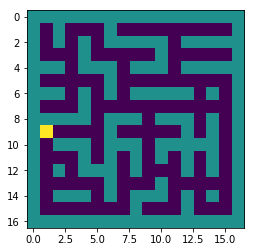

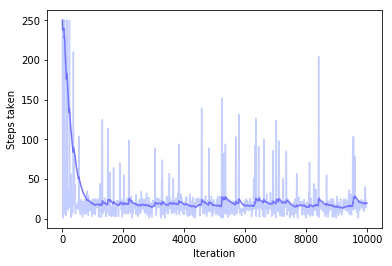

Policy reached goal in 12 steps


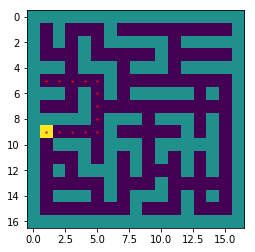

In [4]:
# quick test...
maze = Maze_MDP(17,17)
maze.generate_random(5)
maze.plot()

agent = Sarsa_Agent(maze)
history = agent.train(iterations=10000, max_steps=250)

BURN_IN = 0

x = [step for (step,steps_taken,reward) in history[BURN_IN:]]
steps_taken = [steps_taken for (step,steps_taken,reward) in history[BURN_IN:]]

plt.plot(x,steps_taken,c="#C4CFFF")
plt.plot(x,smooth(steps_taken), c="#7474FF")
plt.ylabel("Steps taken")
plt.xlabel("Iteration")
plt.show()

agent.show_policy()

# 2. POMDP

Observation is the 4 adjacent walls.. 
Extension is walls are correct with probability 0.9

Look into algorithms for solving this.
Some ideas are
* FRL
* RNN
* Normal method.. but this will probably not work...

## 2.1 Sarsa (POMDP)

First we show that the standard MDP algorithms do not work on this modified problem.  This is because the observation space is no longer the same as the state space, and so we have aliasing

In [5]:
class Agent():
    
    def __init__(self, env):
        self.env = env
        
    def show_policy(self):
        # display our policy        

        plt.imshow(self.env.tile)
        
        obs = self.env.reset()
        
        x,y = self.env.state
        history = [(x,y,0)]
        
        for i in range(100):
            # take determinstic policy
            a = self.policy_action(obs) 
            obs, _, _, _ = self.env.step(int(a))
            x,y = self.env.state
            history.append((x, y, i+1))
            if (x,y) == self.env.goal:
                print("reached goal in {} steps".format(i+1))
                break

        X = [x for (x,y,c) in history]
        Y = [y for (x,y,c) in history]
        C = [c for (x,y,c) in history]
                        
        plt.scatter(Y,X,c='red',s = 25.0/self.env.width)
        plt.show()

    
class Sarsa_POMDP(Agent):
    """ Sarsa algroithm, for partial observations """
    
    def __init__(self, env):
        super().__init__(env)
        self.Q = np.zeros((16,len(env.ACTIONS)))
        self.alpha = 0.5
        self.gamma = 1.0
        self.epsilon = 0.1
            
    def policy_action(self, state, eps=None):
        """ returns sampled policy action at given state."""
        if np.random.rand() < (eps if eps is not None else self.epsilon):
            return np.random.randint(len(self.env.ACTIONS))
        else:            
            return np.random.choice(np.flatnonzero(self.Q[state] == self.Q[state].max()))                                
            
    def train(self, iterations=100, max_steps=100):
        """ Train the agent.
            Returns evaluations at various intervals.
        """
        
        EVAL_EVERY = 10
        
        history = []
        for n in range(iterations):
            obs = self.env.reset()
            a = self.policy_action(obs)
            total_reward = 0
            for step in range(max_steps):
                (new_obs, reward, done, info) = self.env.step(int(a))
                a_ = self.policy_action(new_obs)
                total_reward += reward
                                                
                self.Q[obs,a] += self.alpha * (reward + self.gamma * self.Q[new_obs, a_] - self.Q[obs,a])
                obs = new_obs
                                
                if done:
                    break
                
            history.append((n, step, total_reward))               
            
        return history

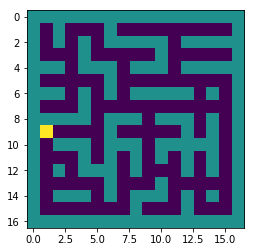

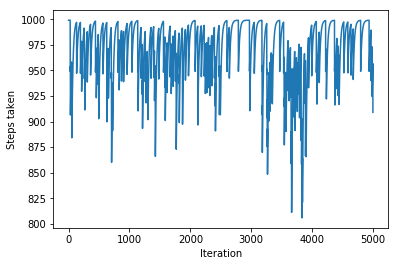

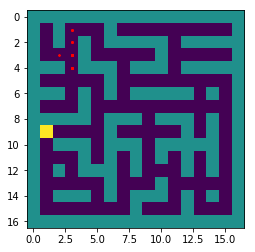

In [6]:
# quick test...
maze = Maze_POMDP(17,17)
maze.generate_random(5)
maze.plot()

agent = Sarsa_POMDP(maze)
history = agent.train(iterations=5000, max_steps=1000)

x = [step for (step,steps_taken,reward) in history]
steps_taken = [steps_taken for (step,steps_taken,reward) in history]

plt.plot(x,smooth(steps_taken))
plt.ylabel("Steps taken")
plt.xlabel("Iteration")
plt.show()

agent.show_policy()

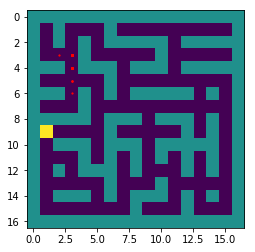

In [7]:
agent.show_policy()

Sarsa fails due to state alaising.  Multiple locations have identical observations.  The problem is therefore not markovian, and some kind of history or memory is required.  Using a less deterministic policy might help a little as we could learn actions as a mixuture of the possiable locations the agent could be in.

# 2.2 Baysian

Maintain a beleif state based on observations and act according to ?most likely? state, or a mixture of the states?

In [135]:
class Baysian_Agent(Agent):
    """ Baysian belief algroithm, for partial observations """
    """ Note:
            I think I could probably do this by updating the belief with every action, but it's easyer to just
            check which states are constant with the history.
    """
    
    def __init__(self, env, Q):
        """ Initialize Baysian Agent, requires Q values for fully observiable version. """
        super().__init__(env)
        
        # calculate Q values using full information
        sub_agent = Sarsa_Agent(env)
        self.Q = Q        
        self.o_probs = self.determine_probs()        
        self.reset_belief()
                
        
    def reset_belief(self):
        # start with a uniform belief over all empty states
        self.belief = np.zeros((self.env.width, self.env.height))
        for x in range(1,self.env.height-1):
            for y in range(1,self.env.width-1):      
                if self.env.tile[x,y] == 0:
                    self.belief[x,y] = 1

        # normalise
        self.belief /= np.sum(self.belief)

        
    def update_belief(self, action, obs):
        """ Update our current belief vector via bayes rule. """
        
        potential_starting_states = 0
        pattern = int_to_bits(obs,4)
        
        new_belief = np.zeros_like(self.belief)
        
        #print("Before update\n", self.belief, "\n")
        
        # first apply the effect of the action on our belief state.
        if action is not None:
            dx,dy = self.env.DELTAS[action]
            for x in range(1,self.env.height-1):
                for y in range(1,self.env.width-1):      
                    if self.env.can_move_to(x+dx, y+dy):
                        new_belief[x+dx,y+dy] += self.belief[x,y]                        
                    else:
                        # we can't make the move so just keep the mass here.
                        new_belief[x,y] += self.belief[x,y]                                                                                                        
            self.belief = new_belief
        
        #print("After action update\n", self.belief, "\n")

        # next apply bayes rule to exclude any states that don't match the current observation                
        if obs is not None:
            for x in range(self.env.height):
                for y in range(self.env.width):                
                    # p(s|o) = p(o|s)p(s) / p(o)
                    if not self.matches_pattern(x,y, pattern):
                        self.belief[x,y] = 0

        #print("After observation update\n", self.belief, "\n")
                        
        # normalising is easyer than finding the correct ratio.
        # but if we did want to do this it's just 1/p(o)
        if np.sum(self.belief) == 0:
            raise Exception("No states match observation history.")
        self.belief /= np.sum(self.belief)
                                            
                
    def matches_pattern(self, x, y, pattern):
        """ Returns if the tile position matches given pattern"""
        if self.env.tile[x,y] == 1: 
            return False
        observed_pattern = [self.env.tile[x+dx,y+dy] == 1 for dx, dy in self.env.DELTAS]
        return tuple(observed_pattern) == tuple(pattern)
        
    def show_belief(self):
        plt.imshow(self.belief * 100 + self.env.tile, vmin=0, vmax=100)
        plt.show()
        
    def determine_probs(self):
        """ Calculate p(o|s) based on map occurrances """
        
        def count_pattern(pattern):
            """ Counters number of times given patern occurs.  Pattern is an array of 4 booleans. """
            counter = 0
            for x in range(self.env.width):
                for y in range(self.env.height):
                    if self.matches_pattern(x,y,pattern):
                        counter += 1                    
            return counter
        
        floor_tiles = (self.env.width*self.env.height) - np.count_nonzero(self.env.tile)
        probs = []
        for obs in range(16):
            probs.append(count_pattern(int_to_bits(obs,4)) / floor_tiles)
        return probs
        
            
    def policy_action(self):
        """ returns policy based on current belief."""                
        # this wasn't working so now I just pick a location and play the best move if I was there.
        pos = []
        for x in range(self.env.width):
            for y in range(self.env.height):
                pos.append((x,y))
        x,y = pos[np.random.choice(range(len(pos)), p=self.belief.ravel())]
        #print("guessed ",x,y," was at ",self.env.state)
        return np.random.choice(np.flatnonzero(self.Q[x,y] == self.Q[x,y].max()))        
        
        """
        
        # this shouldn't be necessary, but at the moment the agent gets stuck and needs a bit of random
        # help to get out.  This either means the q values are wrong, or something in my policy decision making
        # is wrong.  Maybe I shouldn't be using argmax?
        #if np.random.rand() < 0.05:
        #    return np.random.randint(len(self.env.ACTIONS))
        
        value = np.array([0 for action in self.env.ACTIONS], dtype=np.float32)
        
        for action in range(4):
            value[action] = np.sum(self.belief*self.Q[:,:,action])
            
        # try softmax
        sm = softmax(value)
        return np.random.choice(range(4), p=sm)
        """
    
    def show_walk(self, max_steps=100):
        obs = self.env.reset()
        self.reset_belief()
        self.update_belief(None, obs)
        for step in range(max_steps):
            a = self.policy_action()
            (obs, reward, done, info) = self.env.step(int(a))
            self.show_belief()
            if done:
                break                
            self.update_belief(a, obs)                
                                
    def train(self, iterations=100, max_steps=100):
        """ Train the agent.
            Returns evaluations at various intervals.
        """
        
        history = []
        for n in range(iterations):
            obs = self.env.reset()
            self.reset_belief()
            self.update_belief(None, obs)
            total_reward = 0
            for step in range(max_steps):
                a = self.policy_action()
                (obs, reward, done, info) = self.env.step(int(a))
                total_reward += reward                                                                                                                
                if done:
                    break                
                self.update_belief(a, obs)                
                                                
            history.append((n, step, total_reward))               
            
        return history

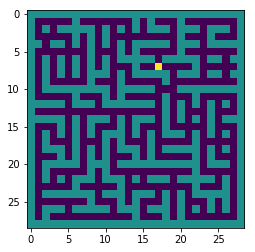

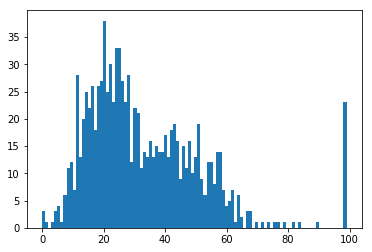

In [138]:
maze = Maze_MDP(29,29)
maze.generate_random(5)
agent = Sarsa_Agent(maze)
agent.train(iterations=5000, max_steps=1000)
q = agent.Q

maze = Maze_POMDP(maze.width,maze.height)
maze.generate_random(5)
maze.plot()

agent = Baysian_Agent(maze,q)
history = agent.train(iterations=1000, max_steps=100)

x = [step for (step,steps_taken,reward) in history]
steps_taken = [steps_taken for (step,steps_taken,reward) in history]

plt.hist(steps_taken,bins=100)
plt.show()

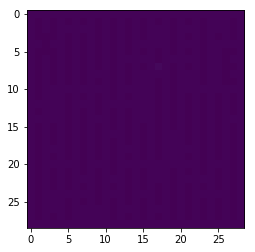

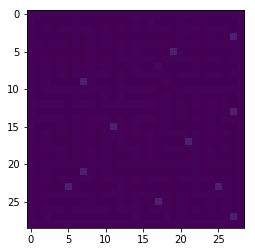

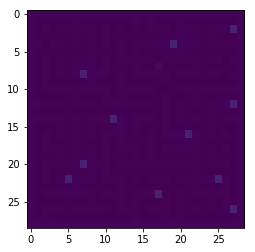

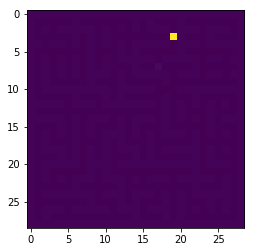

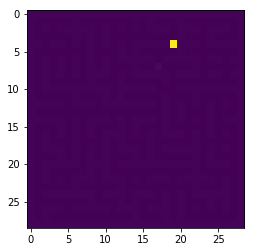

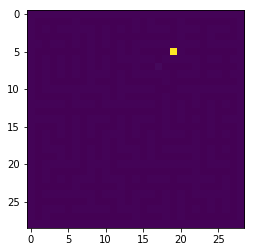

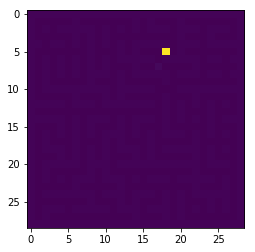

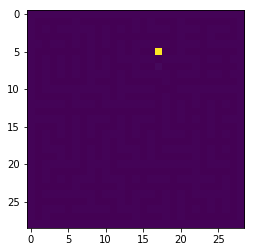

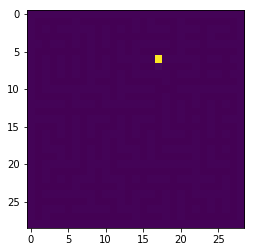

In [137]:
# show belief walk :)
agent.show_walk()